Import tools and define files

In [9]:
import argparse
import itertools
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

EDGELIST = 'umdEdges.csv'
NODELIST = 'umdPOI.csv'
OUTPUT_CSV = 'short_graph.py'
OUTPUT_GML = 'short_graph.gml'

In [10]:
def create_complete_graph(pair_weights, flip_weights=True):
    '''create a complete graph from the pair weights'''
    graph = nx.Graph()
    for k, v in pair_weights.items():
        wt_i = -v if flip_weights else v
        graph.add_edge(k[0], k[1], weight=wt_i)
    return graph

In [11]:
def get_shortest_paths_distance(graph, pairs, edge_weight_name='weight'):
    '''get the shortest path distances between all pairs of nodes'''
    distances = {}
    for pair in pairs:
        distances[pair] = nx.dijkstra_path_length(graph, pair[0], pair[1], weight=edge_weight_name)
    return distances


In [12]:
# def get_data():
# parser = argparse.ArgumentParser(description='gets the minimum number of edges to connect all nodes in a graph')
# parser.add_argument('--edges', required=False, type=str)
# parser.add_argument('--nodes', required=False, type=str)
# args = parser.parse_args()

edgelist = pd.read_csv(EDGELIST)
nodelist = pd.read_csv(NODELIST)

graph=nx.Graph()
for _, elrow in edgelist.iterrows():
    graph.add_edge(elrow[0], elrow[1], weight = elrow[2])

for _, nlrow in nodelist.iterrows():
    graph.add_node(nlrow[0], attr_dict=nlrow[1:].to_dict())

node_positions = {}
for node in graph.nodes(data=True):
    node_positions[node[0]] = (node[1]['attr_dict']['longitude'],
                               node[1]['attr_dict']['latitude'])



In [13]:

nodes_odd_degree = [v for v, d in graph.degree() if d % 2 == 1]


In [14]:
odd_node_pairs = list(itertools.combinations(nodes_odd_degree, 2))
# odd_node_pairs

In [15]:
odd_node_pairs_shortest_paths = get_shortest_paths_distance(graph, odd_node_pairs, 'weight')

In [16]:
g_odd_complete = create_complete_graph(odd_node_pairs_shortest_paths, flip_weights=True)

In [17]:
odd_matching_dupes = nx.algorithms.max_weight_matching(g_odd_complete, True)
odd_matching = list(pd.unique([tuple(sorted([k,v])) for k, v in odd_matching_dupes]))

True


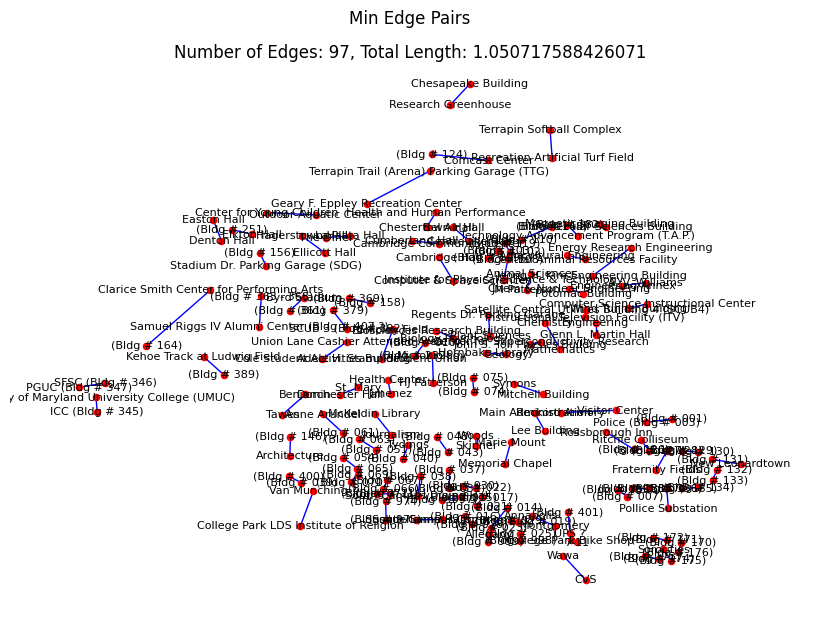

In [18]:
g_odd_complete_min_edges = nx.Graph(odd_matching_dupes)

# print(g_odd_complete_min_edges.edges())
#print(odd_node_pairs_shortest_paths)

print(('Research Greenhouse','Chesapeake Building') in odd_node_pairs_shortest_paths.keys())

min_pairs_total_length=0
for pair in g_odd_complete_min_edges.edges():
    if(pair[1],pair[0]) in odd_node_pairs_shortest_paths.keys():
        min_pairs_total_length+=odd_node_pairs_shortest_paths[(pair[1],pair[0])]
    #print((pair[1],pair[0]) in odd_node_pairs_shortest_paths.keys())

#min_pairs_total_length = sum(int(odd_node_pairs_shortest_paths[(pair[1], pair[0])]) for pair in g_odd_complete_min_edges.edges() if (pair[1], pair[0]) in odd_node_pairs_shortest_paths.keys())

plt.figure(figsize=(8,6))
nx.draw(g_odd_complete_min_edges, pos = node_positions,
        node_size=20, edge_color='b',node_color='r', with_labels=True, font_size=8)
plt.title("Min Edge Pairs")
plt.suptitle(F"Number of Edges: {len(odd_matching)}, Total Length: {min_pairs_total_length}")
plt.show()

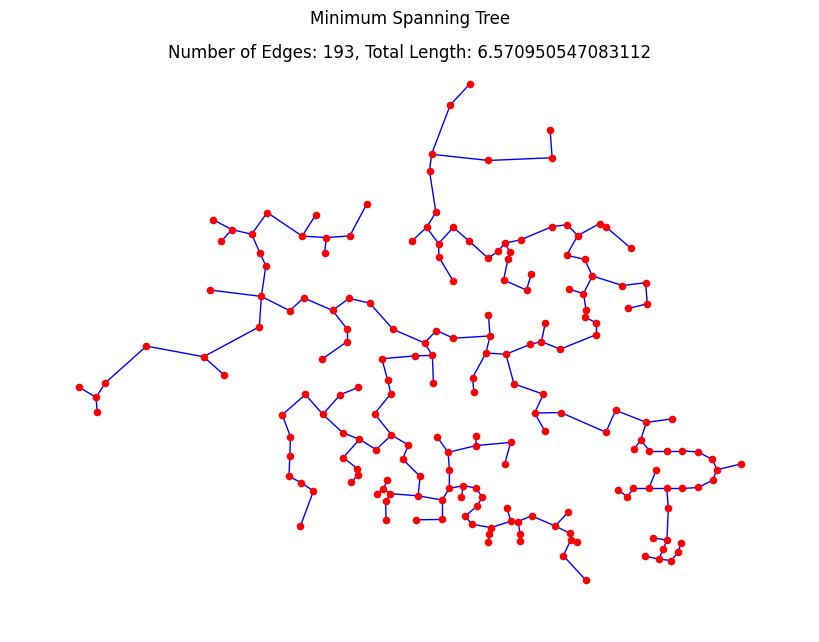

In [19]:
min_graph = nx.minimum_spanning_tree(graph)

min_graph_total_length = sum([d['weight'] for _, _, d in min_graph.edges(data=True)])

plt.figure(figsize=(8,6))
nx.draw(min_graph, pos = node_positions,
        node_size=20, edge_color='b',node_color='r')
plt.title(f"Minimum Spanning Tree")
plt.suptitle(f"Number of Edges: {min_graph.number_of_edges()}, Total Length: {min_graph_total_length}")
plt.show()

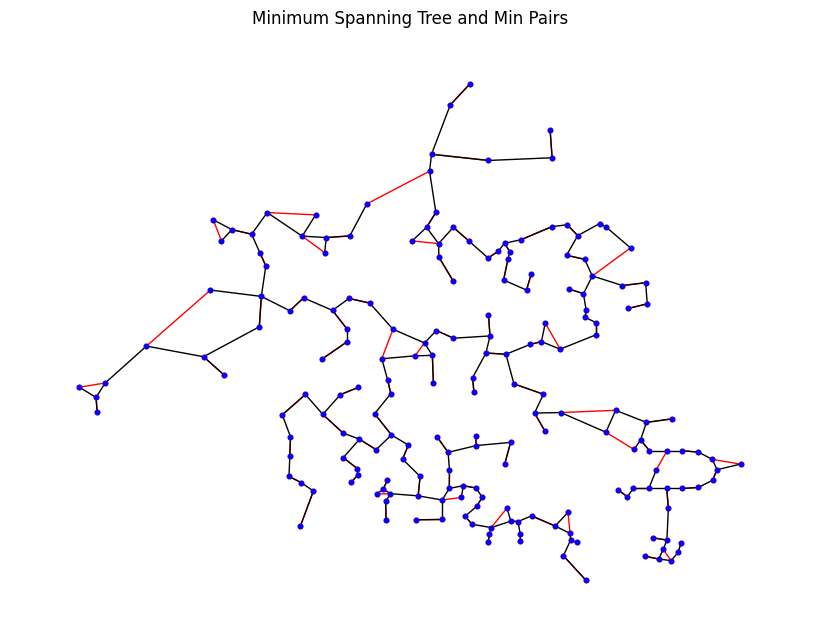

In [20]:
plt.figure(figsize=(8,6))
nx.draw(g_odd_complete_min_edges, pos=node_positions, node_size=10, node_color='r', edge_color='r', with_labels=False)
nx.draw(min_graph, pos=node_positions, node_size=10, node_color='b', with_labels=False)
plt.title(f'Minimum Spanning Tree and Min Pairs')
plt.suptitle
plt.show()

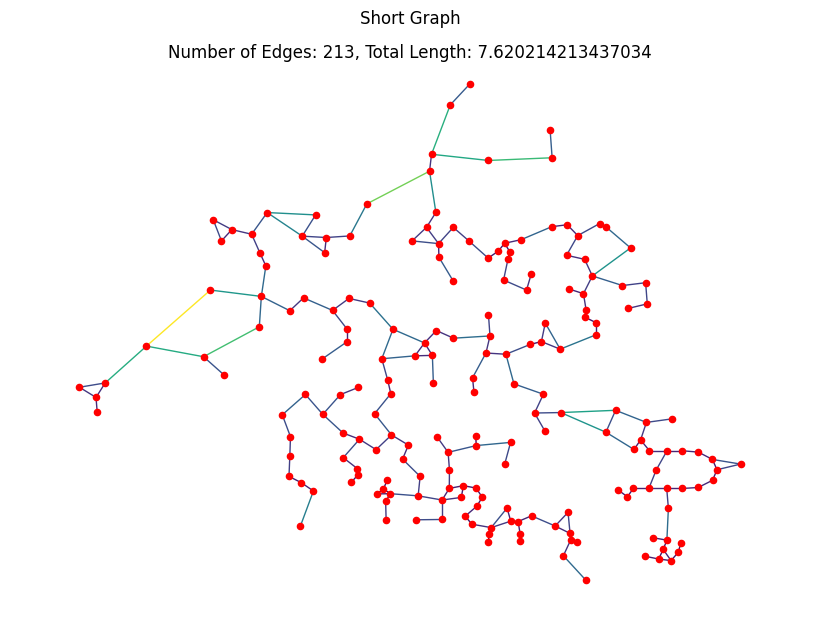

In [21]:
short_graph = nx.Graph()
for node in min_graph.nodes():
    short_graph.add_node(node, attr_dict=graph.nodes[node]['attr_dict'])
for edge in min_graph.edges():
    short_graph.add_edge(edge[0], edge[1], weight=graph.edges[edge]['weight'])
for edge in g_odd_complete_min_edges.edges():
    if (edge not in short_graph.edges()) & ((edge[1], edge[0]) not in short_graph.edges()):
        short_graph.add_edge(edge[0], edge[1], weight=graph.edges[edge]['weight'])



short_graph_total_length = sum([d['weight'] for _, _, d in short_graph.edges(data=True)])
# print(short_graph_total_length)

plt.figure(figsize=(8,6))
#create a range for edge colors based on the weights from blue to red
edge_colors = [short_graph[u][v]['weight'] for u,v in short_graph.edges()]

nx.draw(short_graph, pos = node_positions,
        node_size=20, edge_color = edge_colors, node_color='r')
plt.title(f"Short Graph")
plt.suptitle(f"Number of Edges: {short_graph.number_of_edges()}, Total Length: {short_graph_total_length}")
plt.show()

In [27]:
'''export the graph to a csv file'''
'''
with open(OUTPUT_CSV, 'w', encoding='utf-8') as file:
    file.write('Source, Target, Distance\n')
    nx.write_edgelist(short_graph, OUTPUT_CSV, delimiter=',', data=['weight'])
'''
nx.write_graphml_lxml(short_graph, "short_graph.graphml")

In [23]:
'''take in a csv file of start and end nodes, then draw paths between them and export in xml format'''
path_nodes = pd.read_csv('short_graph.csv')
print(path_nodes)

Empty DataFrame
Columns: [Source,  Target,  Distance]
Index: []
